# Hystersis Analysis

In [5]:
#std lib
import numpy as np
import matplotlib.pyplot as plt
import math
#non-std lib

In [6]:
# paths
csv_path_uart = "UART.csv"
csv_path_embedded = "embedded.csv"

## Methods

In [7]:
def csv2array(csv_path, column_realtemp, column_settemp):
    """
    Input:
    Output:
        1. array [[<real temp>], [<desired temp>]]
    """
    with open(csv_path, 'rb') as csv_file:
        data = np.loadtxt(csv_file,delimiter = ",",skiprows=2)[:,[column_realtemp, column_settemp]]
    return data

def plt_data(real_temp, set_temp):
    """
    """
    print(f"length= {len(set_temp)}")
    plt.plot(range(len(set_temp)), set_temp)
    plt.plot(range(len(set_temp)), real_temp)
    plt.show()
    
def get_data_at_values(real_temp, set_temp):
    """
    """
    filtered_data = []
    current_temp = set_temp[0]
    hasbeen_below = False
    hasbeen_above = False
    for index in range(len(real_temp)):
        if set_temp[index] != current_temp:
            current_temp = set_temp[index]
            hasbeen_below = False
            hasbeen_above = False
        if real_temp[index] <= current_temp:
            hasbeen_below = True
        else:
            hasbeen_above = True
        if hasbeen_below and hasbeen_above:
            filtered_data.append([real_temp[index], set_temp[index]])
    return np.array(filtered_data)

def get_realtemp_per_settemp(real_temp_filtered, set_temp_filtered):
    """
    """
    current_temp = set_temp_filtered[0]
    temp_map = {current_temp: []}
    for index in range(len(real_temp_filtered)):
        if set_temp_filtered[index] != current_temp:
            current_temp = set_temp_filtered[index]
            temp_map[current_temp] = []
        else:
            temp_map[current_temp].append(real_temp_filtered[index])
            
    return temp_map

def filter_temps(real_temp_filtered, set_temp_filtered, temp_filter=80):
    """
    """
    filtered_data = []
    for index in range(len(real_temp_filtered)):
        if math.ceil(set_temp_filtered[index]) == temp_filter:
            filtered_data.append([real_temp_filtered[index], set_temp_filtered[index]])
    return np.array(filtered_data)

def get_error_per_settemp(real_temp_filtered, set_temp_filtered):
    """
    """
    temp_map = get_realtemp_per_settemp(real_temp_filtered, set_temp_filtered)
    error_map = []
    for settemp, realtemp_array in temp_map.items():
        temp_arr = []
        for realtemp in realtemp_array:
            error = abs(realtemp - settemp)
            temp_arr.append(error)
        overall_error = np.average(temp_arr)
        error_map.append([math.ceil(settemp), round(overall_error,3)])
            
    return np.array(error_map)

In [8]:
# parse experimental csv files
uart_data = csv2array(csv_path_uart, 1, 4)
embedded_data = csv2array(csv_path_embedded, 1, 2)

In [9]:
# filter data for values only once set point reached, not transitions
embedded_data_filtered = get_data_at_values(embedded_data[80:,0], embedded_data[80:,1])
uart_data_filtered = get_data_at_values(uart_data[:,0], uart_data[:,1])

In [10]:
# obtain errors
map1 = get_error_per_settemp(embedded_data_filtered[:,0], embedded_data_filtered[:,1])
map2 = get_error_per_settemp(uart_data_filtered[:,0], uart_data_filtered[:,1])

In [11]:
embedded_data_filtered2 = filter_temps(embedded_data_filtered[:,0], embedded_data_filtered[:,1], temp_filter=60)
uart_data_filtered2 = filter_temps(uart_data_filtered[:,0], uart_data_filtered[:,1], temp_filter=60)

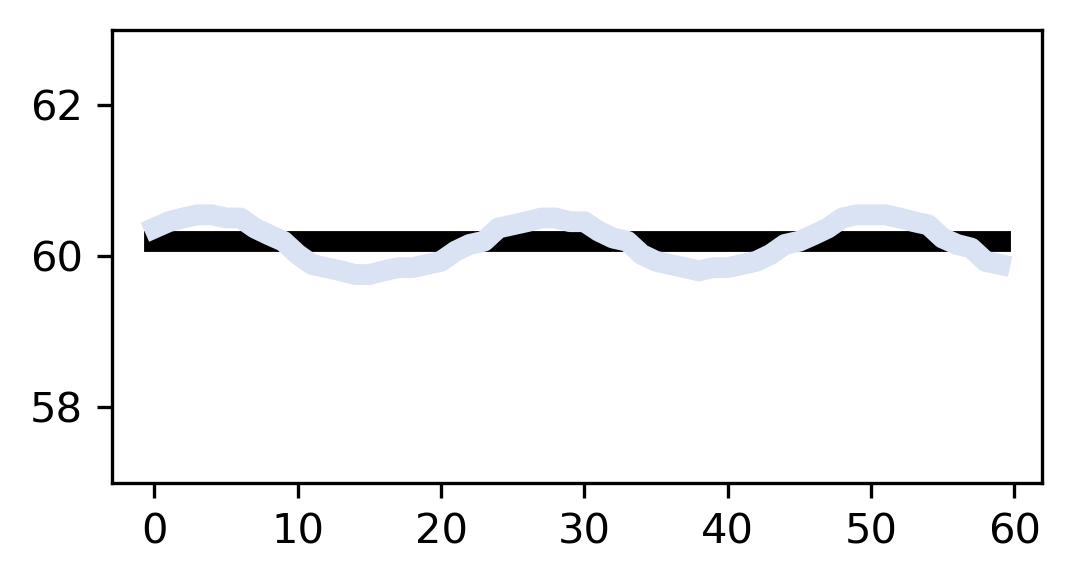

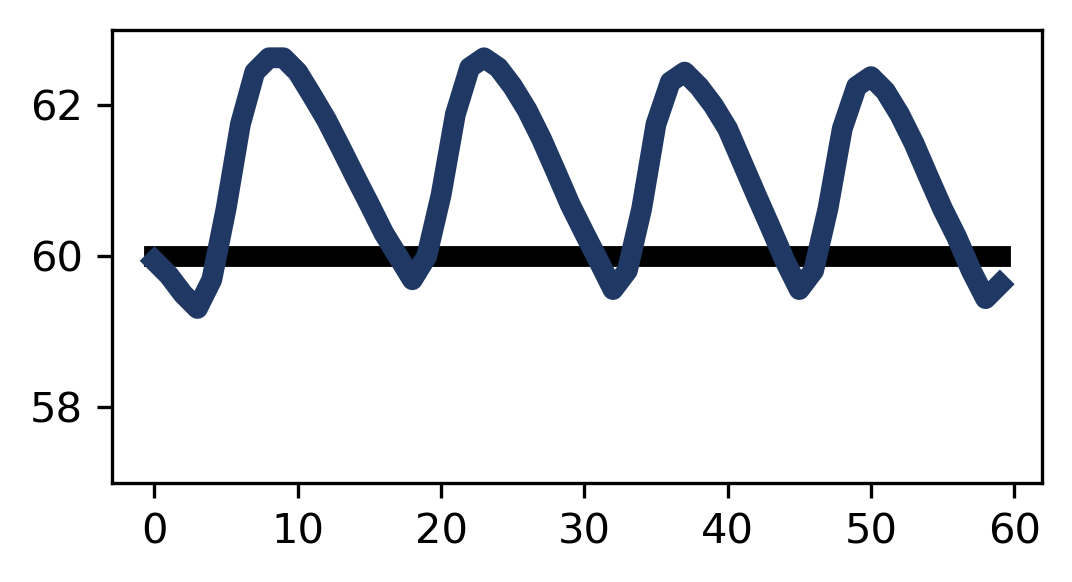

In [17]:
# find min and max
max_temp = max(uart_data_filtered2[:,1])-3
min_temp = min(uart_data_filtered2[:,1])+3

# embedded (need to rescale to account for setting at 69.4)
plt.figure(figsize=(4,2), dpi=300)
plt.plot(range(len(embedded_data_filtered2[:60,0])), embedded_data_filtered2[:60,1]+.6, linewidth=5, color='black')
plt.plot(range(len(embedded_data_filtered2[:60,0])), embedded_data_filtered2[:60,0]+.6, linewidth=5, color='#DAE3F3')
plt.ylim(max_temp, min_temp)
plt.show()

# UART
plt.figure(figsize=(4,2), dpi=300)
plt.plot(range(len(uart_data_filtered2[:60,0])), uart_data_filtered2[:60,1], linewidth=5, color='black')
plt.plot(range(len(uart_data_filtered2[:60,0])), uart_data_filtered2[:60,0], linewidth=5, color='#203864')
plt.ylim(max_temp, min_temp)
plt.show()

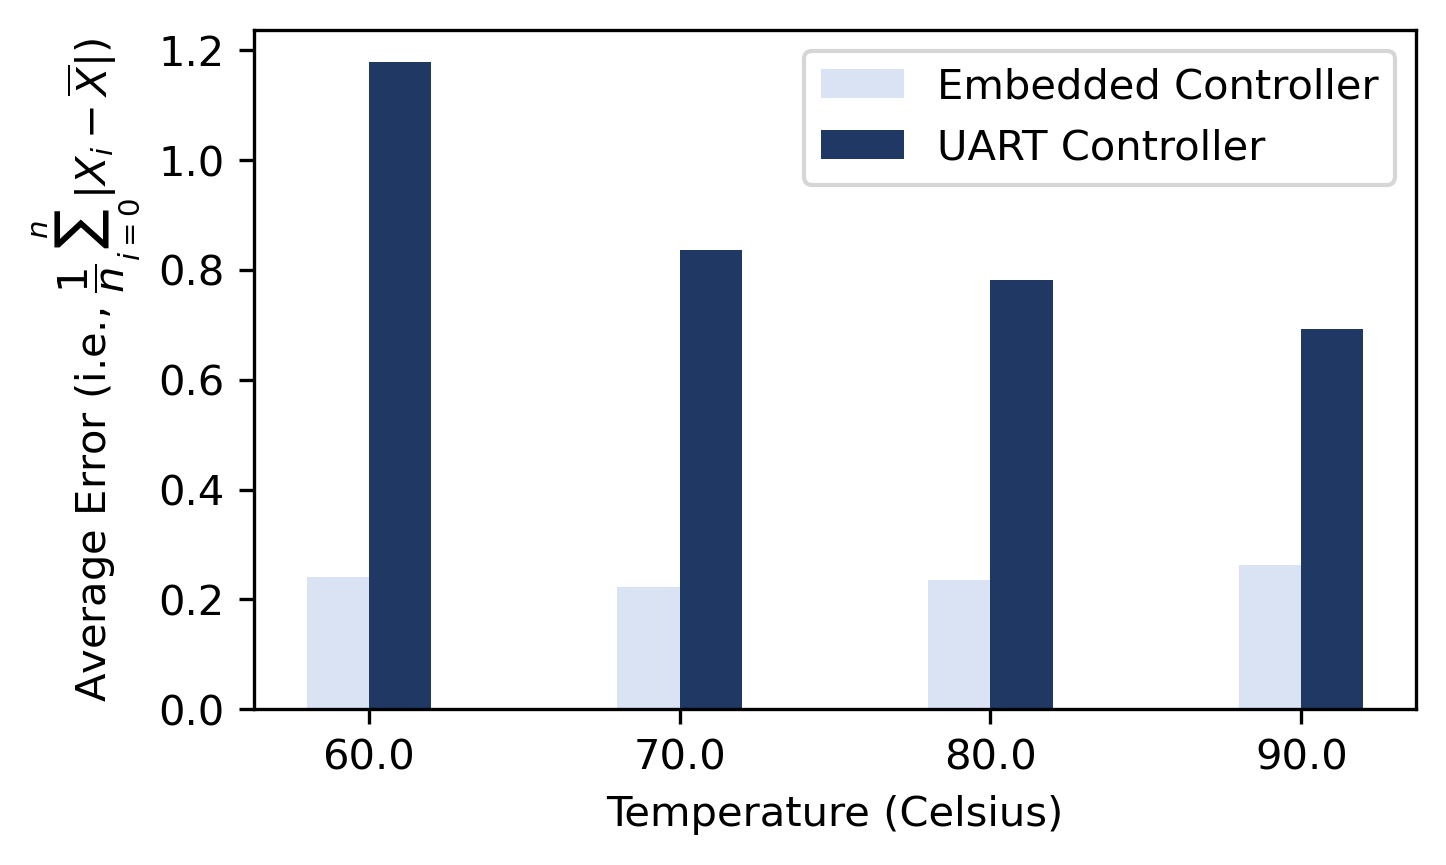

In [19]:
plt.figure(figsize=(5,3), dpi=300)
plt.bar(map1[:,0]-1, map1[:,1], color='#DAE3F3', label="Embedded Controller", width=2)#, edgecolor='black')
plt.bar(map2[:,0]+1, map2[:,1], color='#203864', label="UART Controller", width=2)#, edgecolor='black')
plt.ylabel("Average Error (i.e., $\dfrac{1}{n}\sum_{i=0}^{n}|X_i-\overline{X}|$)")
plt.xlabel("Temperature (Celsius)")
plt.xticks(map1[:,0], map1[:,0])
plt.legend()
plt.show()